In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from modules.db_manager import table_to_dataframe

In [ ]:
df = table_to_dataframe(db_name="crispr_sgRNA.db", table_name="clean_data")

## EDA

Посмотрим на типы данных и количество пропусков в столбцах: 

In [3]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  26248 non-null  object 
 1   perfect_match_sgRNA  26248 non-null  object 
 2   gene                 26248 non-null  object 
 3   sgRNA_sequence       26248 non-null  object 
 4   mismatch_position    26248 non-null  int64  
 5   new_pairing          26248 non-null  object 
 6   K562                 26248 non-null  int64  
 7   Jurkat               26248 non-null  int64  
 8   mean_relative_gamma  26248 non-null  float64
 9   genome_input         26248 non-null  object 
 10  sgRNA_input          26248 non-null  object 
 11  encoded_or           26248 non-null  object 
 12  encoded_stacked      26248 non-null  object 
 13  encoded_7channels    26248 non-null  object 
 14  gc_content           26248 non-null  float64
 15  pam                  26248 non-null 

Для числовых столбцов посмотрим на основные статистики:

In [4]:
df.describe()

,mismatch_position,K562,Jurkat,mean_relative_gamma,gc_content
count,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000
mean,-9.053490,0.852713,0.543432,0.280410,0.687885
std,4.946003,0.354399,0.498120,0.389325,0.084510
min,-19.000000,0.000000,0.000000,-0.319067,0.384615
25%,-12.000000,1.000000,0.000000,-0.003163,0.615385
50%,-9.000000,1.000000,1.000000,0.058403,0.692308
75%,-5.000000,1.000000,1.000000,0.564199,0.730769
max,-1.000000,1.000000,1.000000,2.278508,0.961538


Посчитаем корреляцию между числовыми переменными:

In [5]:
df.corr(method='pearson', numeric_only=True)

,mismatch_position,K562,Jurkat,mean_relative_gamma,gc_content
mismatch_position,1.000000,0.005308,0.007886,-0.583286,0.025128
K562,0.005308,1.000000,-0.380945,0.003082,-0.081635
Jurkat,0.007886,-0.380945,1.000000,-0.008141,0.000281
mean_relative_gamma,-0.583286,0.003082,-0.008141,1.000000,0.073448
gc_content,0.025128,-0.081635,0.000281,0.073448,1.000000


In [6]:
df.corr(method='spearman', numeric_only=True)

,mismatch_position,K562,Jurkat,mean_relative_gamma,gc_content
mismatch_position,1.000000,0.004255,0.008163,-0.537291,0.024265
K562,0.004255,1.000000,-0.380945,0.016620,-0.078312
Jurkat,0.008163,-0.380945,1.000000,-0.009089,0.001432
mean_relative_gamma,-0.537291,0.016620,-0.009089,1.000000,0.064414
gc_content,0.024265,-0.078312,0.001432,0.064414,1.000000


Явную корреляцию таргетная переменная имеет только с признаком *mismatch_position*

Распределение некоторых признаков:

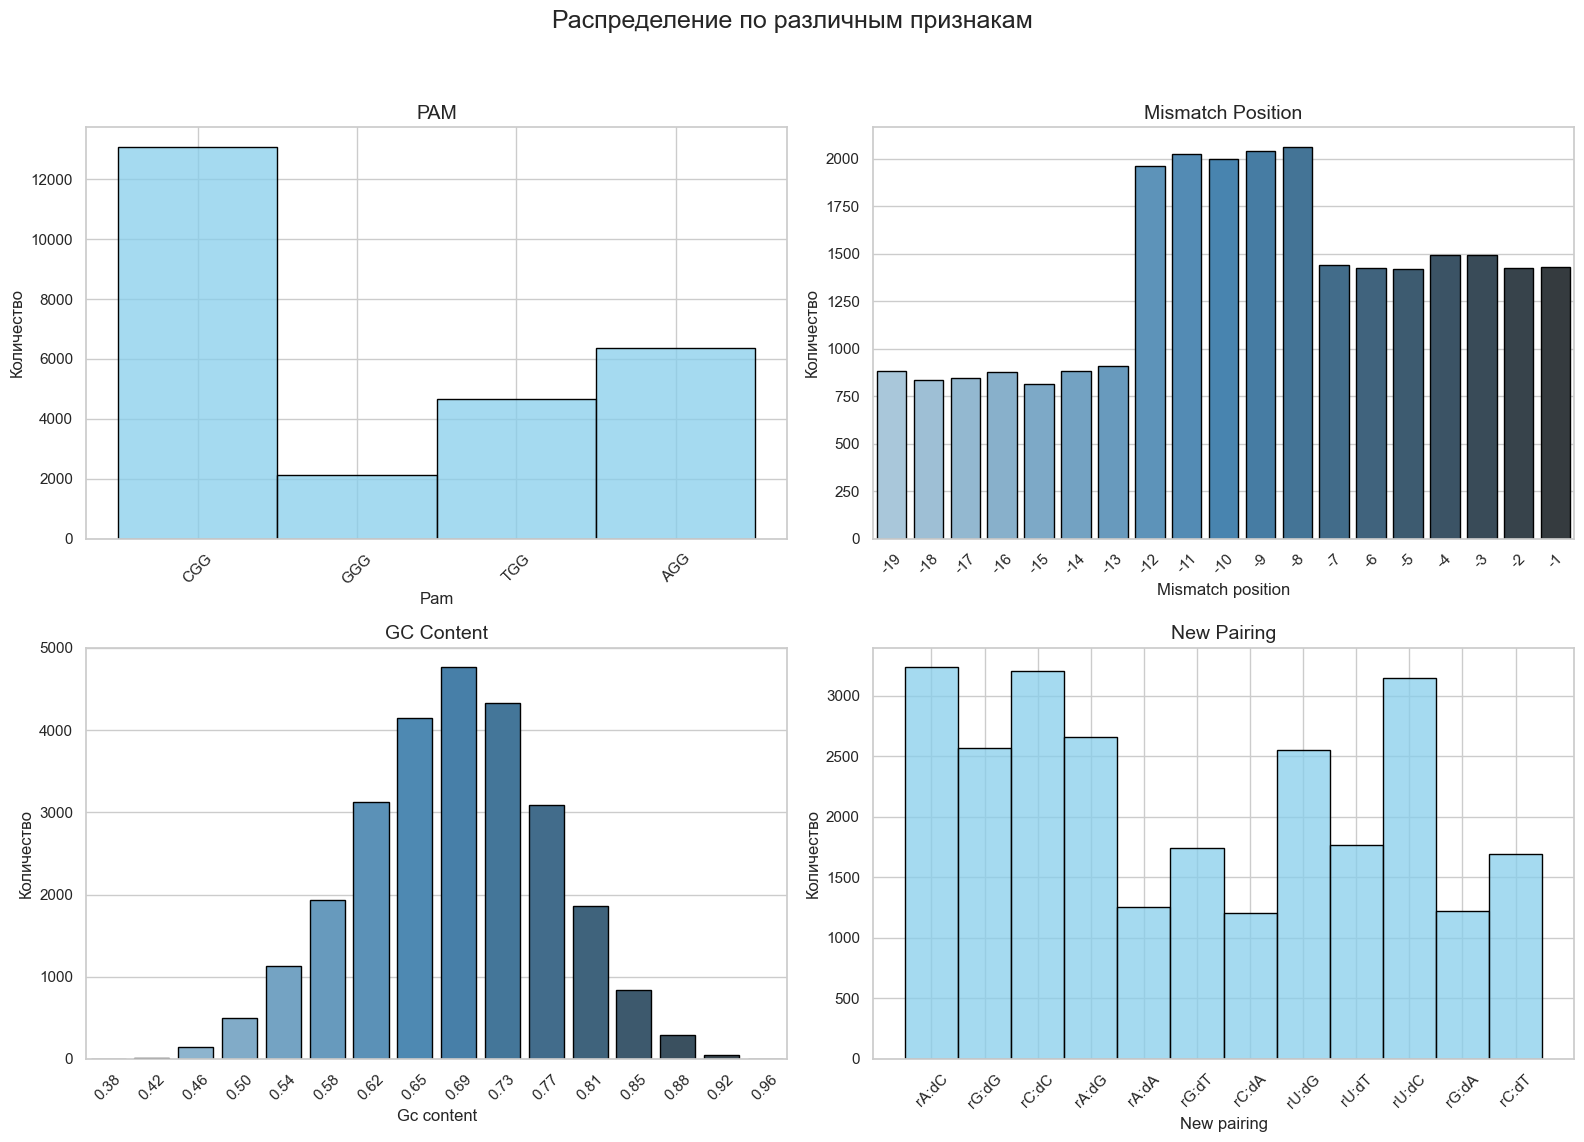

In [7]:
sns.set(style="whitegrid")

df['mismatch_position'] = df['mismatch_position'].astype('category')

def format_gc_content(x):
    if isinstance(x, (float, int)):
        return f"{x:.2f}"
    return x

df['gc_content'] = df['gc_content'].apply(format_gc_content).astype('category')

columns = ["pam", "mismatch_position", "gc_content", "new_pairing"]
titles = ["PAM", "Mismatch Position", "GC Content", "New Pairing"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (col, title) in enumerate(zip(columns, titles)):
    if col in ['mismatch_position', 'gc_content']:
        sns.countplot(
            data=df,
            x=col,
            hue=col,
            palette='Blues_d',
            edgecolor='black',
            ax=axes[i]
        )
        
        if axes[i].get_legend() is not None:
            axes[i].get_legend().remove()
    else:
        sns.histplot(
            data=df,
            x=col,
            kde=False,
            color='skyblue',
            edgecolor='black',
            ax=axes[i]
        )
    
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel(col.replace('_', ' ').capitalize(), fontsize=12)
    axes[i].set_ylabel('Количество', fontsize=12)
    
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Распределение по различным признакам", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Построим распределение таргетной величины:

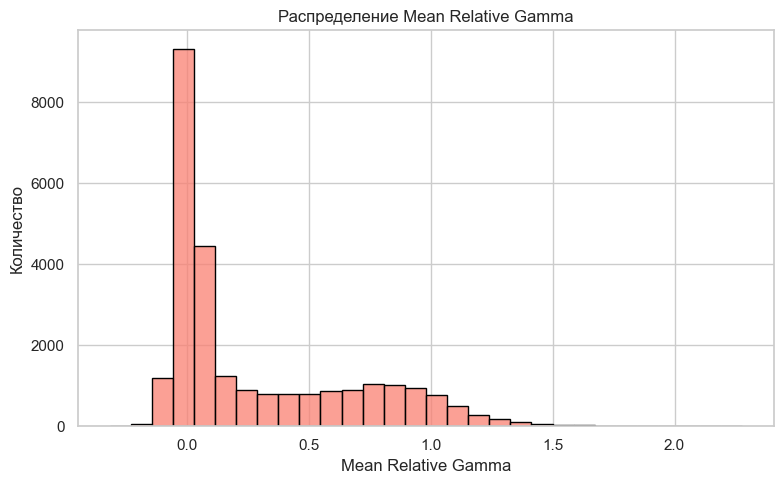

In [18]:
plt.figure(figsize=(8, 5))

sns.histplot(data=df, x="mean_relative_gamma", bins=30, color='salmon', edgecolor='black')

plt.title("Распределение Mean Relative Gamma")
plt.xlabel("Mean Relative Gamma")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

Распределение таргетной величины по группам PAM:

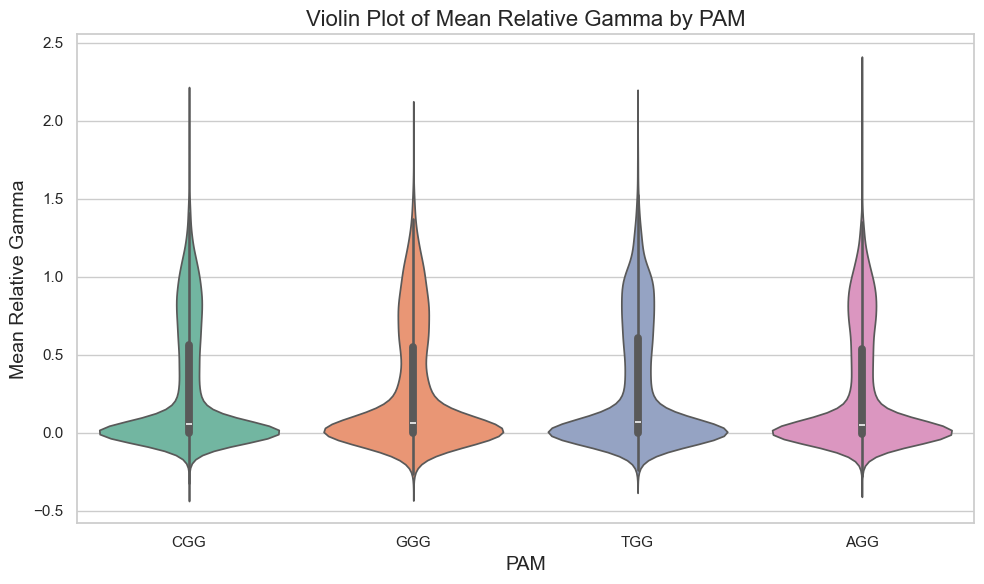

In [17]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df,
    x='pam',
    y='mean_relative_gamma',
    inner='box',
    hue='pam',
    palette='Set2',
    dodge=False
)

plt.title("Violin Plot of Mean Relative Gamma by PAM", fontsize=16)
plt.xlabel("PAM", fontsize=14)
plt.ylabel("Mean Relative Gamma", fontsize=14)
plt.xticks()

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

Распределение таргетной величины в зависимости от mismatch_position:

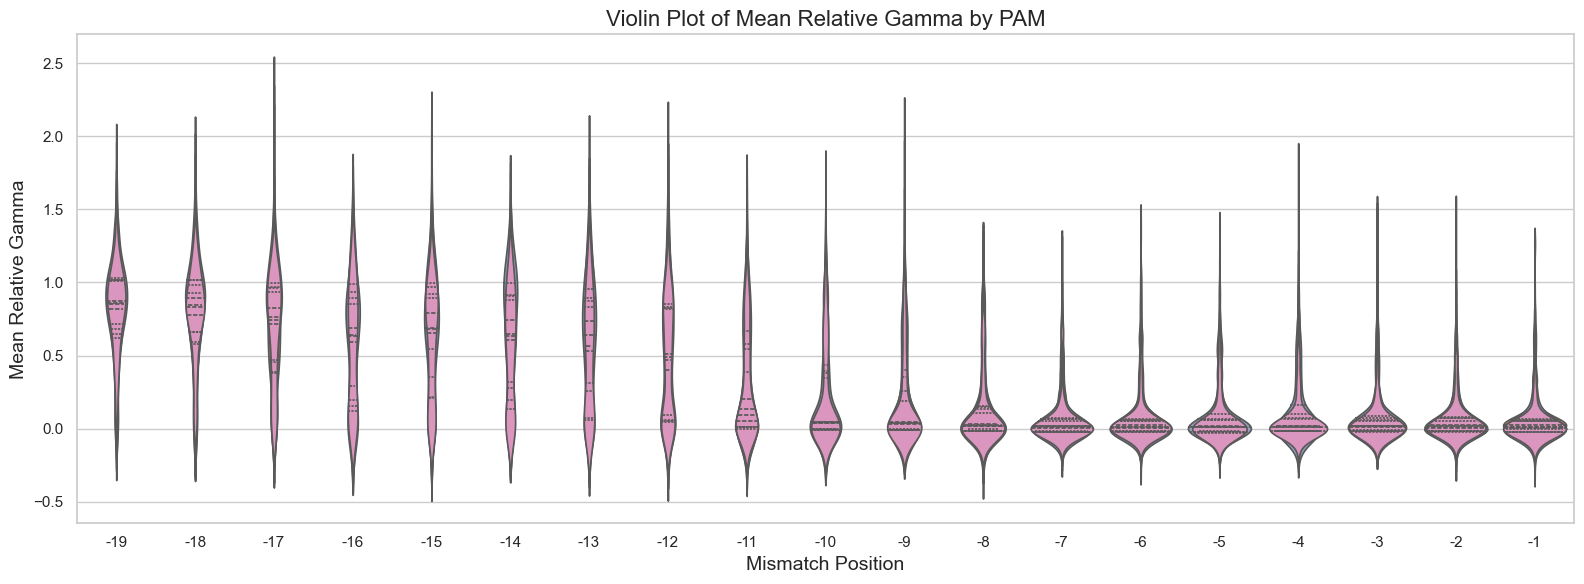

In [15]:
plt.figure(figsize=(16, 6))

sns.violinplot(
    data=df,
    x='mismatch_position',
    y='mean_relative_gamma',
    inner='quarth',
    hue='pam',
    palette='Set2',
    dodge=False
)

plt.title("Violin Plot of Mean Relative Gamma by PAM", fontsize=16)
plt.xlabel("Mismatch Position", fontsize=14)
plt.ylabel("Mean Relative Gamma", fontsize=14)
plt.xticks()

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()